In [1]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value.

The question is that how to determine the threshold. In this notebook, we will find the best split point for a threshold.

# Data set

In [2]:
# Ref: https://github.com/serengil/deepface/tree/master/tests/dataset
idendities = {
    "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg", "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
    "Scarlett": ["img8.jpg", "img9.jpg"],
    "Jennifer": ["img3.jpg", "img12.jpg"],
    "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
    "Jack": ["img16.jpg", "img17.jpg"],
    "Elon": ["img18.jpg", "img19.jpg"],
    "Jeff": ["img20.jpg", "img21.jpg"],
    "Marissa": ["img22.jpg", "img23.jpg"],
    "Sundar": ["img24.jpg", "img25.jpg"]
}

# Positive samples
Find different photos of same people

In [3]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [4]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

# Negative samples
Compare photos of different people

In [5]:
samples_list = list(idendities.values())

In [6]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
        

In [7]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

# Merge Positives and Negative Samples

In [8]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [9]:
df.shape

(300, 3)

In [10]:
df.decision.value_counts()

No     262
Yes     38
Name: decision, dtype: int64

In [11]:
df.file_x = "D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/"+df.file_x
df.file_y = "D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/"+df.file_y

# DeepFace

In [12]:
import sys
import os
 

parent = os.path.dirname('tests')
sys.path.append(parent)
sys.path.insert(0, 'D:\FYP_code\FYP_Model_code_API')

from  deepface import DeepFace

In [13]:
instances = df[["file_x", "file_y"]].values.tolist()

In [14]:
model_name = "ArcFace"
distance_metric = "cosine"

In [15]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'saved_model8/my_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [ ]:
df["distance"] = distances

# Analyzing Distances

In [ ]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)

In [ ]:
print("Mean of true positives: ", tp_mean)
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Mean of true positives:  0.3475
Std of true positives:  0.1559
Mean of false positives:  0.965
Std of false positives:  0.0965


# Distribution

<AxesSubplot:ylabel='Density'>

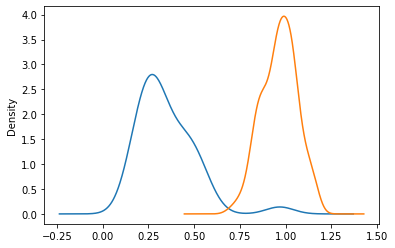

In [ ]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

# Best Split Point

In [ ]:
!pip install chefboost
from chefboost import Chefboost as chef

  Using cached chefboost-0.0.17-py3-none-any.whl (26 kB)
  Using cached psutil-5.9.4-cp36-abi3-win_amd64.whl (252 kB)


In [ ]:
config = {'algorithm': 'C4.5'}

In [ ]:
tmp_df = df[['distance', 'decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)

[INFO]:  4 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  9.512629270553589  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.66666666666667 % on  300  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[37, 0], [1, 262]]
Precision:  100.0 %, Recall:  97.3684 %, F1:  98.6667 %


# Sigma

In [ ]:
sigma = 2
#2 sigma corresponds 95.45% confidence, and 3 sigma corresponds 99.73% confidence

threshold = round(tp_mean + sigma * tp_std, 4)
# threshold = 0.3147 #comes from c4.5 algorithm
print("threshold: ", threshold)

threshold:  0.6593


In [ ]:
df[df.decision == 'Yes'].distance.max()

0.9678

In [ ]:
df[df.decision == 'No'].distance.min()

0.6912

# Evaluation

In [ ]:
df["prediction"] = "No"

In [ ]:
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [ ]:
df.sample(5)

,file_x,file_y,decision,distance,prediction
258,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,No,0.9422,No
57,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,No,0.9434,No
143,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,No,0.8729,No
213,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,No,0.8603,No
248,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,D:/FYP_code/FYP_MODEL_CODE_API/tests/dataset/i...,No,1.1815,No


In [ ]:
cm = confusion_matrix(df.decision.values, df.prediction.values)

In [ ]:
cm

array([[262,   0],
       [  1,  37]], dtype=int64)

In [ ]:
tn, fp, fn, tp = cm.ravel()

In [ ]:
tn, fp, fn, tp

(262, 0, 1, 37)

In [ ]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [ ]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  100.0 %
Recall:  97.36842105263158 %
F1 score  98.66666666666666 %
Accuracy:  99.66666666666667 %


In [ ]:
df.to_csv("threshold_pivot.csv", index = False)

## Test results

### Threshold = 0.3147 (C4.5 best split point)

Precision:  100.0 %

Recall:  89.47368421052632 %

F1 score  94.44444444444444%

Accuracy:  98.66666666666667 %

### Threshold = 0.3751 (2 sigma)

Precision:  90.47619047619048 %

Recall:  100.0 %

F1 score  95.0 %

Accuracy:  98.66666666666667 %